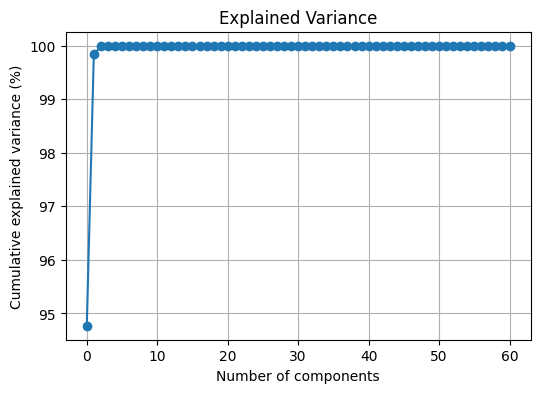

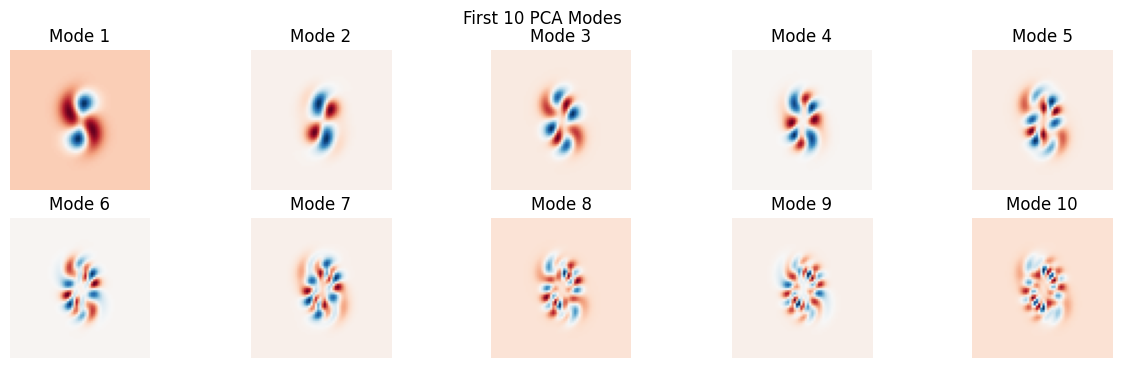

interactive(children=(IntSlider(value=5, description='n_components', max=30, min=1), Output()), _dom_classes=(…

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.fft import fft2, ifft2, fftfreq
from sklearn.decomposition import PCA
from IPython.display import HTML, display
import ipywidgets as widgets
import pandas as pd

# ==========================================================
# Part A: Data generator
# ==========================================================
def fps(nx, ny, dx, dy, f):
    rhs = f[1:nx+1, 1:ny+1]
    f_hat = fft2(rhs)
    kx = fftfreq(nx, d=dx/(2*np.pi))
    ky = fftfreq(ny, d=dy/(2*np.pi))
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    ksq = kx**2 + ky**2
    ksq[0,0] = 1.0
    psi_hat = -f_hat / ksq
    psi_hat[0,0] = 0.0
    ut = np.real(ifft2(psi_hat))
    u = np.empty((nx+3, ny+3))
    u[1:nx+1, 1:ny+1] = ut
    u[:, ny+1] = u[:, 1]
    u[nx+1, :] = u[1, :]
    u[nx+1, ny+1] = u[1,1]
    return u

def bc(nx,ny,u):
    u[:,0] = u[:,ny]
    u[:,ny+2] = u[:,2]
    u[0,:] = u[nx,:]
    u[nx+2,:] = u[2,:]
    return u

def rhs(nx,ny,dx,dy,re,w,s,x,y,ts):
    aa = 1.0/(dx*dx)
    bb = 1.0/(dy*dy)
    gg = 1.0/(4.0*dx*dy)
    hh = 1.0/3.0
    f = np.zeros((nx+3,ny+3))

    j1 = gg*((w[2:nx+3,1:ny+2]-w[0:nx+1,1:ny+2])*(s[1:nx+2,2:ny+3]-s[1:nx+2,0:ny+1]) \
             -(w[1:nx+2,2:ny+3]-w[1:nx+2,0:ny+1])*(s[2:nx+3,1:ny+2]-s[0:nx+1,1:ny+2]))
    j2 = gg*( w[2:nx+3,1:ny+2]*(s[2:nx+3,2:ny+3]-s[2:nx+3,0:ny+1]) \
            - w[0:nx+1,1:ny+2]*(s[0:nx+1,2:ny+3]-s[0:nx+1,0:ny+1]) \
            - w[1:nx+2,2:ny+3]*(s[2:nx+3,2:ny+3]-s[0:nx+1,2:ny+3]) \
            + w[1:nx+2,0:ny+1]*(s[2:nx+3,0:ny+1]-s[0:nx+1,0:ny+1]))
    j3 = gg*( w[2:nx+3,2:ny+3]*(s[1:nx+2,2:ny+3]-s[2:nx+3,1:ny+2]) \
            - w[0:nx+1,0:ny+1]*(s[0:nx+1,1:ny+2]-s[1:nx+2,0:ny+1]) \
            - w[0:nx+1,2:ny+3]*(s[1:nx+2,2:ny+3]-s[0:nx+1,1:ny+2]) \
            + w[2:nx+3,0:ny+1]*(s[2:nx+3,1:ny+2]-s[1:nx+2,0:ny+1]) )
    jac = (j1+j2+j3)*hh

    lap = aa*(w[2:nx+3,1:ny+2]-2.0*w[1:nx+2,1:ny+2]+w[0:nx+1,1:ny+2]) \
        + bb*(w[1:nx+2,2:ny+3]-2.0*w[1:nx+2,1:ny+2]+w[1:nx+2,0:ny+1])

    f[1:nx+2,1:ny+2] = -jac + lap/re 
    return f

def vm_ic(nx,ny,x,y):
    w = np.empty((nx+3,ny+3))
    sigma = np.pi
    xc1, yc1 = np.pi-np.pi/4.0, np.pi
    xc2, yc2 = np.pi+np.pi/4.0, np.pi
    w[1:nx+2, 1:ny+2] = np.exp(-sigma*((x[0:nx+1, 0:ny+1]-xc1)**2 + (y[0:nx+1, 0:ny+1]-yc1)**2)) \
                       + np.exp(-sigma*((x[0:nx+1, 0:ny+1]-xc2)**2 + (y[0:nx+1, 0:ny+1]-yc2)**2))
    return bc(nx,ny,w)

def generate_vortex_data(nd=64, nt=200, re=560.0, dt=0.01, save_freq=10):
    nx, ny = nd, nd
    lx, ly = 2.0*np.pi, 2.0*np.pi
    dx, dy = lx/nx, ly/ny
    x, y = np.meshgrid(np.linspace(0.0,2.0*np.pi,nx+1),
                       np.linspace(0.0,2.0*np.pi,ny+1), indexing='ij')

    w = vm_ic(nx,ny,x,y)
    s = fps(nx, ny, dx, dy, -w); s = bc(nx,ny,s)
    t = np.empty_like(w)
    r = np.empty_like(w)

    snapshots = [np.copy(w)]
    aa, bb = 1/3, 2/3

    for k in range(1, nt+1):
        time = k*dt
        r = rhs(nx,ny,dx,dy,re,w,s,x,y,time)

        # RK3 stages
        t[1:nx+2,1:ny+2] = w[1:nx+2,1:ny+2] + dt*r[1:nx+2,1:ny+2]
        t = bc(nx,ny,t)
        s = fps(nx, ny, dx, dy, -t); s = bc(nx,ny,s)
        r = rhs(nx,ny,dx,dy,re,t,s,x,y,time)

        t[1:nx+2,1:ny+2] = 0.75*w[1:nx+2,1:ny+2] + 0.25*t[1:nx+2,1:ny+2] + 0.25*dt*r[1:nx+2,1:ny+2]
        t = bc(nx,ny,t)
        s = fps(nx, ny, dx, dy, -t); s = bc(nx,ny,s)
        r = rhs(nx,ny,dx,dy,re,t,s,x,y,time)

        w[1:nx+2,1:ny+2] = aa*w[1:nx+2,1:ny+2] + bb*t[1:nx+2,1:ny+2] + bb*dt*r[1:nx+2,1:ny+2]
        w = bc(nx,ny,w)
        s = fps(nx, ny, dx, dy, -w); s = bc(nx,ny,s)

        if k % save_freq == 0:
            snapshots.append(np.copy(w))

    snapshots = np.array(snapshots)   # (n_snaps, nx+3, ny+3)
    data = snapshots[:, 1:nx+1, 1:ny+1]   # drop ghost cells
    n_frames, nx_eff, ny_eff = data.shape
    X = data.reshape(n_frames, -1).T      # (n_pixels, n_frames)
    return data, X

# ==========================================================
# Part B: PCA with interactive controls + mode visualization
# ==========================================================
def run_pca_interactive(data, X):
    n_frames, nx_eff, ny_eff = data.shape

    # Full PCA
    pca = PCA()
    X_scores = pca.fit_transform(X.T)
    explained_var = np.cumsum(pca.explained_variance_ratio_)*100

    # Explained variance plot
    plt.figure(figsize=(6,4))
    plt.plot(explained_var, marker='o')
    plt.xlabel("Number of components")
    plt.ylabel("Cumulative explained variance (%)")
    plt.title("Explained Variance")
    plt.grid()
    plt.show()

    # First 10 PCA modes
    fig, axes = plt.subplots(2, 5, figsize=(15,4))
    for i, ax in enumerate(axes.flat):
        mode = pca.components_[i].reshape(nx_eff, ny_eff)
        ax.imshow(mode, cmap='RdBu')
        ax.set_title(f"Mode {i+1}")
        ax.axis("off")
    plt.suptitle("First 10 PCA Modes")
    plt.show()

    # Interactive widget
    def update(n_components=5):
        # Reduced PCA
        pca_red = PCA(n_components=n_components)
        X_scores_red = pca_red.fit_transform(X.T)
        X_recon = pca_red.inverse_transform(X_scores_red).T
        X_recon = X_recon.reshape(nx_eff, ny_eff, n_frames).transpose(2,0,1)
        error = data - X_recon

        # Memory usage
        original_mem = X.nbytes
        reduced_mem = X_scores_red.nbytes + pca_red.components_.nbytes
        compression = reduced_mem/original_mem
        mse = np.mean(error**2)

        print(f"Components: {n_components}")
        print(f"Original memory: {original_mem/1e6:.2f} MB")
        print(f"Reduced memory: {reduced_mem/1e6:.2f} MB")
        print(f"Compression ratio: {compression:.2%}")
        print(f"Reconstruction MSE: {mse:.4e}")

        # Animation
        fig, axes = plt.subplots(1, 3, figsize=(12,4))
        titles = ["Original", "Reconstructed", "Error"]

        ims = []
        for i in range(n_frames):
            im_list = []
            for ax, arr, title in zip(axes, [data, X_recon, error], titles):
                im = ax.imshow(arr[i], cmap='RdBu', animated=True)
                ax.set_title(title)
                ax.axis("off")
                im_list.append(im)
            ims.append(im_list)

        ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True)
        plt.close(fig)
        display(HTML(ani.to_jshtml()))
    return widgets.interact(update, n_components=widgets.IntSlider(min=1, max=30, step=1, value=5))

# ==========================================================
# Run everything
# ==========================================================
data, X = generate_vortex_data(nd=64, nt=600, save_freq=10)
run_pca_interactive(data, X);


Injected outliers in frames: [52 30 27 17 25 37  7 36 46 56]

=== PCA on Corrupted Data ===


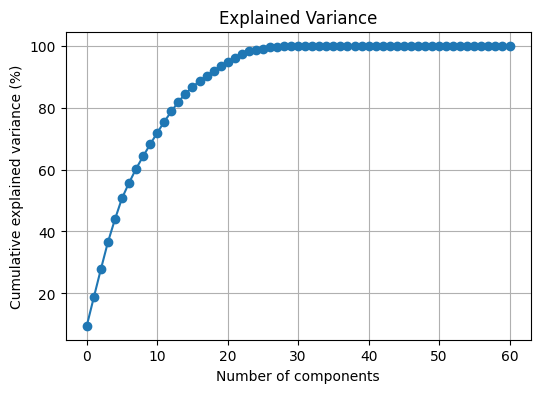

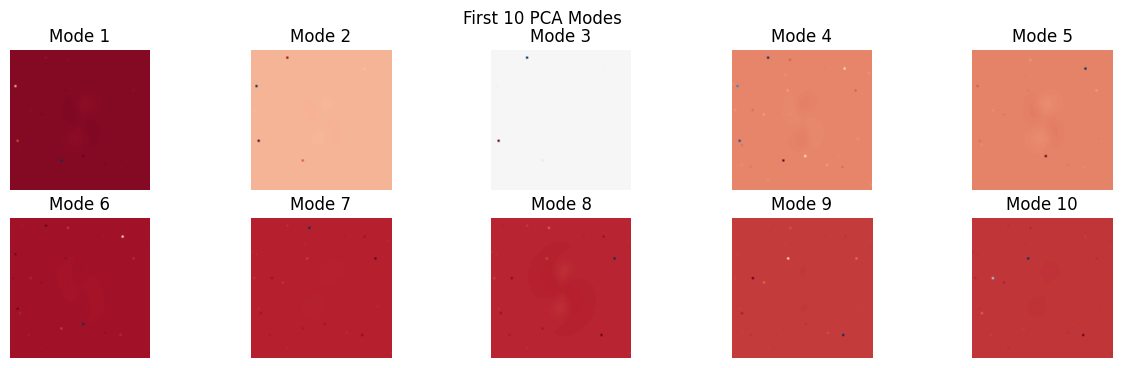

interactive(children=(IntSlider(value=5, description='n_components', max=30, min=1), Output()), _dom_classes=(…

<function __main__.run_pca_interactive.<locals>.update(n_components=5)>

In [6]:
# ==========================================================
# Part C: Add outliers
# ==========================================================
def add_outliers(data, n_outliers=20, outlier_range=(-50,50)):
    n_frames, nx, ny = data.shape
    df = pd.DataFrame(data.reshape(n_frames, -1))
    n_outliers = min(n_outliers, n_frames)
    outlier_indices = np.random.choice(df.index, n_outliers, replace=False)

    for index in outlier_indices:
        col = np.random.choice(df.columns)
        df.at[index, col] = np.random.uniform(*outlier_range)

    data_out = df.values.reshape(n_frames, nx, ny)
    return data_out, outlier_indices

data_out, idx = add_outliers(data, n_outliers=30)
print(f"Injected outliers in frames: {idx[:10]}")

X_out = data_out.reshape(data_out.shape[0], -1).T

print("\n=== PCA on Corrupted Data ===")
run_pca_interactive(data_out, X_out)


=== Running Robust PCA ===



=== First 10 RPCA Modes (from Low-Rank L) ===


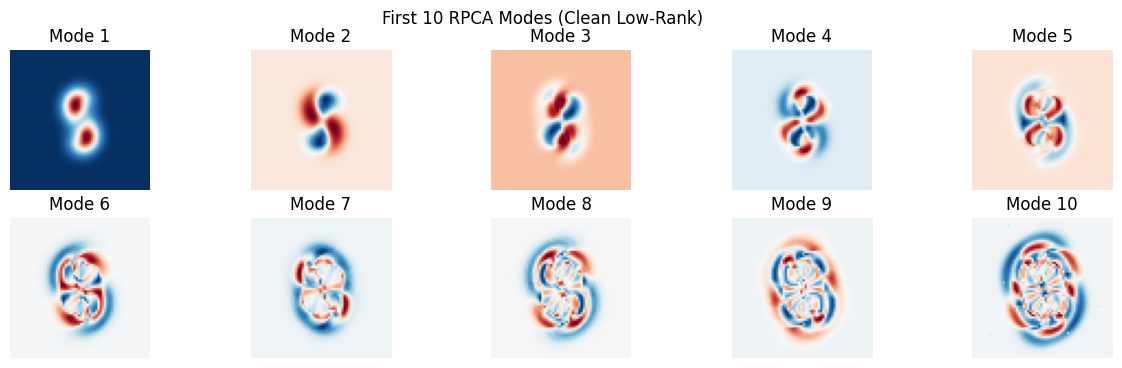

In [7]:
# ==========================================================
# Part C: Robust PCA (IALM method)
# ==========================================================
def robust_pca(M, lam=None, mu=None, max_iter=1000, tol=1e-7):
    """
    Robust PCA via Inexact Augmented Lagrange Multiplier (IALM).
    Decomposes M into:
        M = L + S
    where L = low-rank, S = sparse outliers.
    """
    m, n = M.shape
    norm_M = np.linalg.norm(M, ord='fro')

    if lam is None:
        lam = 1 / np.sqrt(max(m, n))
    if mu is None:
        mu = (m * n) / (4.0 * np.sum(np.abs(M)))

    L = np.zeros((m, n))
    S = np.zeros((m, n))
    Y = np.zeros((m, n))

    for _ in range(max_iter):
        U, sigma, VT = np.linalg.svd(M - S + (1/mu)*Y, full_matrices=False)
        sigma_thresh = np.maximum(sigma - 1/mu, 0)
        L = U @ np.diag(sigma_thresh) @ VT

        residual = M - L + (1/mu)*Y
        S = np.sign(residual) * np.maximum(np.abs(residual) - lam/mu, 0)

        Z = M - L - S
        Y = Y + mu * Z

        err = np.linalg.norm(Z, ord='fro') / norm_M
        if err < tol:
            break

    return L, S


print("\n=== Running Robust PCA ===")
L, S = robust_pca(X_out)

# Reshape back to frames
n_frames, nx, ny = data_out.shape
L_frames = L.T.reshape(n_frames, nx, ny)
S_frames = S.T.reshape(n_frames, nx, ny)

# Animate comparison
fig, axes = plt.subplots(1, 3, figsize=(12,4))
titles = ["Corrupted Data", "RPCA Low-Rank (Clean)", "RPCA Sparse (Outliers)"]

ims = []
for i in range(n_frames):
    im_list = []
    for ax, arr, title in zip(axes, [data_out, L_frames, S_frames], titles):
        im = ax.imshow(arr[i], cmap='RdBu', animated=True)
        ax.set_title(title)
        ax.axis("off")
        im_list.append(im)
    ims.append(im_list)

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True)
plt.close(fig)
display(HTML(ani.to_jshtml()))

# ==========================================================
# Plot first few RPCA modes
# ==========================================================
print("\n=== First 10 RPCA Modes (from Low-Rank L) ===")
U_L, sigma_L, VT_L = np.linalg.svd(L, full_matrices=False)

fig, axes = plt.subplots(2, 5, figsize=(15,4))
for i, ax in enumerate(axes.flat):
    if i < U_L.shape[1]:
        mode = U_L[:, i].reshape(nx, ny)
        im = ax.imshow(mode, cmap="RdBu")
        ax.set_title(f"Mode {i+1}")
        ax.axis("off")
plt.suptitle("First 10 RPCA Modes (Clean Low-Rank)")
plt.show()
